<div style="text-align: left">
[<img src="img/logoUPSayPlusCDS_990.png" width="800px">](http://www.datascience-paris-saclay.fr)
</div>

# [RAMP](https://www.ramp.studio/problems/mars_craters) on Mars craters detection

_Alexandre Boucaud (CDS), Joris van den Bossche (CDS), Balazs Kegl (CDS), Frédéric Schmidt (GEOPS), Anthony Lagain (GEOPS)_

1. [Introduction](#Introduction)
2. [Preprocessing](#Preprocessing)
3. [Workflow](#Workflow)
4. [Evaluation](#Scoring)
5. [Local testing/exploration](#Local-testing)
6. [Submission](#Submitting-to-ramp.studio)

## Introduction

Impact craters in planetary science are used to date planetary surfaces, to characterize surface processes and to study the upper crust of terrestrial bodies in our Solar System (Melosh, 1989). Thanks to the Martian crater morphology, a wide amount of information could be deduced on the geological history of Mars, as for example the evolution of the surface erosion rate, the presence of liquid water in the past, the volcanic episodes or the volatiles layer in the subsurface (Carr & Head, 2010). These studies are widely facilitated by the availability of reference crater databases. 

Surveying impact craters is therefore an important task which traditionally has been achieved by means of visual inspection of images. The enormous number of craters smaller than one kilometer in diameter, present on high resolution images, makes visual counting of such craters impractical. In order to overcome this problem, several algorithms have been developed to automatically detect impact structures on planetary images (Bandeira et al., 2007 ; Martins et al., 2009). Nevertheless, these method allow to detect only 70-80 % of craters (Urbach & Stepinski, 2009).

### The prediction task

This challenge proposes to design the best algorithm to detect crater position and size starting from the most complete Martian crater database containing 384 584 verified impact structures larger than one kilometer of diameter (Lagain et al. 2017). We propose to give to the users a subset of this large dataset in order to test and calibrate their algorithm. 

<img src="img/craters_sample.png" width="70%">
<div style="text-align: center">Example of THEMIS reprojected data</div>


We provide THEMIS nightime dataset (Christensen et al., 2003)
already projected to avoid distortion, sampled at various scales and positions in form 224x224 pixels images. Using an appropriate metric, we will compare the true solution to the estimation. The goal is to provide detection of more than 90% (crater center and diameter) with a minimum number of wrong detection.

### References

1. Bandeira, L.; Saraiva, J. & Pina, P., Impact Crater Recognition on Mars Based on a Probability Volume Created by Template Matching, IEEE Transactions on Geoscience and Remote Sensing, Institute of Electrical and Electronics Engineers (IEEE), 2007, 45, 4008-4015 

2. Carr, M. H. and Head, J. W. III. (2010) Geologic history of Mars. Earth and Planetary Science Letters, 294, 185-203.

3. Christensen, P. R.; Bandfield, J. L.; Bell, J. F.; Gorelick, N.; Hamilton, V. E.; Ivanov, A.; Jakosky, B. M.; Kieffer, H. H.; Lane, M. D.; Malin, M. C.; McConnochie, T.; McEwen, A. S.; McSween, H. Y.; Mehall, G. L.; Moersch, J. E.; Nealson, K. H.; Rice, J. W.; Richardson, M. I.; Ruff, S. W.; Smith, M. D.; Titus, T. N. & Wyatt, M. B., Morphology and Composition of the Surface of Mars: Mars Odyssey THEMIS Results, Science, 2003, 300, 2056-2061 

4. Lagain, A., Marmo, C., Delaa, O., Bouley, S., Baratoux, D., Costard, F. et al. (2017) Martian crater database: 1. Reviewing and adapting to surface ages measurement. Submission to the Journal of Geophysical Research planned to November 2017.

5. Martins, R.; Pina, P.; Marques, J.S & Silveira, M., Crater Detection by a Boosting Approach, IEEE Geoscience and Remote Sensing Letters, Institute of Electrical and Electronics Engineers (IEEE), 2009, 6, 127-131

6. Melosh, H. J. (1989) Impact cratering: a geologic process. Oxford University Press.

7. Urbach, E. and Stepinski, T. (2009) Automatic detection of sub-km craters in high resolution planetary images. Planetary and Space Science, 57, 880-887.

## Preprocessing

### From raw data to local quadrangles

The full THEMIS map of Mars has been saved in a cylindrical projection.    Raw visualization of the full map is thus quite difficult.

<img src="img/full_image.png" width="80%">
<div style="text-align: center">Raw THEMIS data</div>

In order to correct for the distortions and recover the circularity of the craters, the map has to be reprojected locally. For that, we use a partitions known as _quadrangles_. 140 quadrangles are used to cover the whole Mars surface and we have used only a few of them for this exercice.

<img src="img/quadrangles.png" width="95%">
<div style="text-align: center">Quadrangle division in the raw THEMIS projection</div>

We use the boundaries of the quadrangle to extract the relevant pixels from the raw THEMIS map (above). Here we choose the quadrangle #77, close to the equator, and thus only slightly distorted.

<img src="img/quad_77_original_small.png" width="80%">
<div style="text-align: center">Quadrangle 77</div>

Then we reproject the pixel to the local stereographic projection in order to correct for the distortions. The result can be seen below.

<img src="img/quad_77_localstereo_small.png" width="80%">
<div style="text-align: center">Quadrangle 77 reprojected</div>

For illustration, we use the crater database to project the labelled craters per category on the reprojected map.

<img src="img/quad_77_local_craters_small.png" width="80%">
<div style="text-align: center">Quadrangle 77 reprojected with labelled craters</div>

### From quadrangles to input data

After selecting a common **shape for the input** of image processing models **224x224**, we start from the reprojected quadrangles and decide to create the patches from a tiling with overlap to cover the craters falling on the edges. The tiling is also performed on downsampled versions of the quadrangles, until all craters can be detected for all sizes of craters present.
With the current set up, the **craters** contained in every image **have radii** that span the range **of 5 to 28 pixels**.

With no further do, let's have a look at the data..

### The input data

#### Download script (optional)

If the data has not yet been downloaded locally, uncomment the following cell and run it.

There are ~800Mb of images.

In [2]:
# !python download_data.py

=> File saved as data/data_train.npy
=> File saved as data/data_test.npy
=> File saved as data/labels_train.csv
=> File saved as data/labels_test.csv


#### Load the data

In [1]:
from __future__ import division, print_function

import os
import numpy as np
import pandas as pd
import rampwf as rw

import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.patches import Circle
%matplotlib inline

In [2]:
X_train = np.load('data/data_train.npy', mmap_mode='r')

print("The train data is made of {} images of {}x{} pixels".format(*X_train.shape))

n_img = len(X_train)

The train data is made of 10000 images of 224x224 pixels


Here we display 3 randomly select images, you can play around with the values.

In [3]:
idx_list = [30, 3470, 9030]

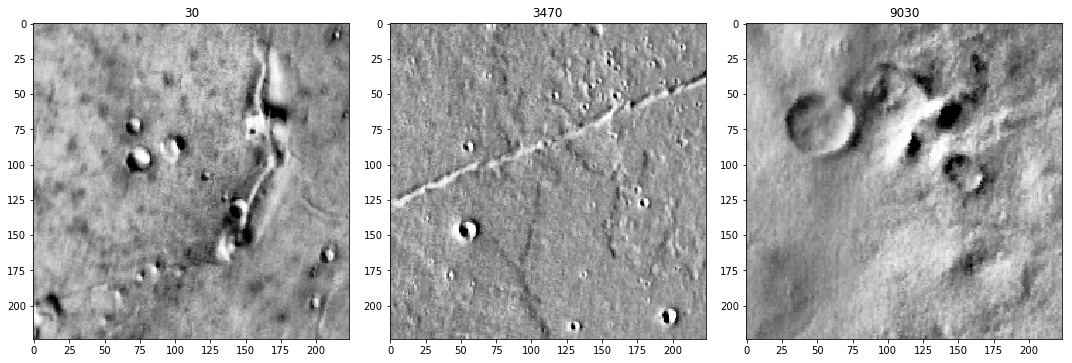

In [4]:
fig, axes = plt.subplots(ncols=3, figsize=(15, 5))
for i, idx in enumerate(idx_list):
    axes[i].imshow(X_train[idx], cmap='Greys_r')
    axes[i].set_title('%d' % idx)
fig.tight_layout()

Most images have some craters but the labeled craters are only the one whose diameter is superior to 10 pixels.

In [5]:
y_train = pd.read_csv('data/labels_train.csv')

In [6]:
y_train.head()

,i,row_p,col_p,radius_p
0,0,57.0,175.0,6.70
1,1,57.0,7.0,6.70
2,4,37.0,70.0,5.25
3,4,121.0,66.0,8.35
4,7,145.0,71.0,6.70


The labels consist of a `pandas.DataFrame` containing the list of craters. For each craters, the columns are
- `id`: index of the image it belongs to
- `row_p`, `col_p` : pixel position
- `radius_p` : pixel radius

Let's visualize some.

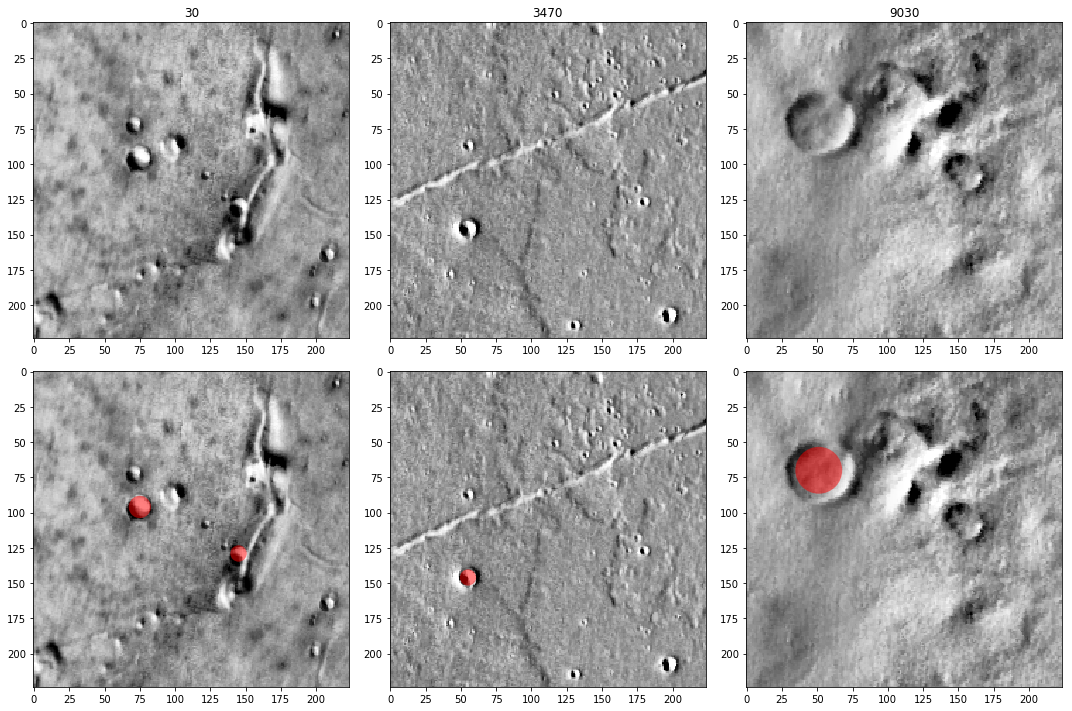

In [7]:
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15, 10))
for i, idx in enumerate(idx_list):
    img = X_train[idx]
    lab = y_train[y_train['i'] == idx][['row_p', 'col_p', 'radius_p']].values
    # First row images only
    axes[0, i].imshow(img, cmap='Greys_r')
    axes[0, i].set_title('%d' % idx)
    # Second row, labels overlaid on the image
    axes[1, i].imshow(img, cmap='Greys_r')
    if lab.size != 0:
        for y, x, radius in lab:
            crater = Circle((x, y), radius, color='r', ec=None, alpha=0.5)
            axes[1, i].add_patch(crater)
fig.tight_layout()

### Labels distribution

#### Individual craters

In [8]:
print("There are {} labeled craters in the training set".format(y_train.size))

There are 32288 labeled craters in the training set


#### Lots of "empty" images

In [9]:
n_img_withcraters = y_train['i'].unique().size

print("There are labeled craters for only {:.1%} of the images".format(n_img_withcraters / n_img))

There are labeled craters for only 49.5% of the images


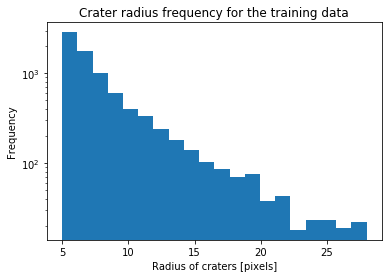

In [10]:
y_train.radius_p.plot(kind='hist', bins=20, log=True)
plt.xlabel('Radius of craters [pixels]')
plt.title('Crater radius frequency for the training data')

## The pipeline

<img src="img/workflow.svg" width="70%">

For submitting at the [RAMP site](http://ramp.studio), you will have to write one class, saved in a specific file:   

* a class `ObjectDetector` that will handle the training and prediction in a `object_detector.py` file.

### Object detector

A dummy object detector which detects a single crater in the middle of each 

In [11]:
# %load submissions/starting_kit/object_detector.py
import numpy as np


class ObjectDetector:
    def __init__(self):
        pass

    def fit(self, X, y):
        return self

    def predict(self, X):
        y_pred = [[(1.0, 112.0, 112.0, 112.0)] for img in X]
        y_pred_array = np.empty(len(y_pred), dtype=object)
        y_pred_array[:] = y_pred
        return y_pred_array


Format of the data it receives:

In [12]:
import problem

In [13]:
X, y = problem.get_train_data()

In [14]:
X.shape

(10000, 224, 224)

A single image patch:

In [15]:
X[0].shape

(224, 224)

The corresponding ground thruth data for that patch consists of a list of tuples (x, y, radius):

In [16]:
y[0]

[(57.0, 175.0, 6.7000000000000002)]

In [17]:
y[2]

[]

In [18]:
y[4]

[(37.0, 70.0, 5.25), (121.0, 66.0, 8.3499999999999996)]

The format returned by the `predict` method contains one extra element: the confidence or score for that predicted crater: `(conf, x, y, radius)`. The returned value in `predict` should then be an array of lists of tuples.

In [19]:
!ramp_test_submission --quick-test

Testing Mars craters detection and classification
Reading train and test files from ./data ...
Reading cv ...
Training ./submissions/starting_kit ...
CV fold 0
	train scp = 0.9969
	valid scp = 1.0
	test scp = 0.9939
	train ospa = 0.9854
	valid ospa = 0.9955
	test ospa = 0.9924
/Users/yetkin/ramp/ramp-workflow/rampwf/score_types/detection.py:453: RuntimeWarning: invalid value encountered in long_scalars
  return n_pred_correct / n_pred_all
/Users/yetkin/ramp/ramp-workflow/rampwf/score_types/detection.py:746: RuntimeWarning: All-NaN slice encountered
  p_at_r.append(np.nanmax(p))
	train map = nan
	valid map = nan
	test map = nan
	train prec(0) = 0.55
	valid prec(0) = 0.4
	test prec(0) = 0.6
	train prec(0.5) = 0.0
	valid prec(0.5) = 0.0
	test prec(0.5) = 0.0
	train prec(0.9) = 0.0
	valid prec(0.9) = 0.0
	test prec(0.9) = 0.0
	train rec(0) = 0.7857
	valid rec(0) = 1.0
	test rec(0) = 0.4091
	train rec(0.5) = 0.0
	valid rec(0.5) = 0.0
	test rec(0.5) = 0.0
	train rec(0.9) = 0.0
	valid rec(0.9

### Scoring

`y_true` and `y_pred` can have variable length

- What is a detection ?
- What is the distance between two lists of predictions ?
- How do we rank the various models ?


#### Intersetion over Union : IoU

Distance in (x, y, r) space computed using IoU (adapted for circles in this problem)

<img src="img/iou_formula.png" width="30%">
<img src="img/iou_examples.png" width="70%">

Detection can start at `IoU > 0` but traditionally an object is detected if **`IoU > 0.5`**.

#### Confidence level

Each prediction should be associated with a confidence, so that they can be ranked. The confidence value should be the first one that appears, before `x, y, radius`.

#### Matching

The Hungarian method [`O(N log(N))`] is used to compute the best match between the true and predicted list.

### Metric #1 Average Precision

- **precision**: fraction of correct predictions
- **recall**: fraction of true objects that are predicted

Precision and recall are computed as a function of the confidence value threshold to produce the mean Average Precision (mAP) curve.

<img src="img/precision-recall-curve.png" width="70%">


### Metric #2 OSPA

[OSPA](http://www.dominic.schuhmacher.name/papers/ospa.pdf) is a miss-distance between the best match of two lists of objects with various size. It penalizes the both the distance between the best match entries and the size difference, referred to as _cardinality_.

The distance used here is the IoU for circles.

<img src="img/ospa_figure2.png" width="80%">
<div style="text-align: center">Various examples of sets of entries and their corresponding OSPA value.</div>

### Metric #3 SCP

_Superposed Cylinders and Prisms_ is a new score based on the projection of true and predicted craters on a rasterized image (mask).

We construct the mask by projecting circles: true craters as positive and predicted ones as negative.

<img src="img/det_mask.png" width="65%">

The craters are **inverse weighted** by their area so the sum over a given crater is normalized to unity.

The **score** is obtained as the sum of the absolute value of the mask.

## Some attention points when building the model

<div class="alert alert-danger">

 <ul>
  <li>In the ground truth labels, **only craters are present with a radius of 5 to 28 pixels**. You should make sure your model also only predicts craters in this range, otherwise it will be penalized for finding (possibly existing) craters not present in the ground truth.</li>
  <li>All metrics, except for Average Precision, are calculated by selecting the set of predictions based on a **confidence threshold of 0.5**. So you should **rescale the returned value of the confidence** so that the best threshold for your model is rescaled to 0.5.</li>
  <li>The data for training and testing comes from different quadrangles of Mars, and can different characteristics (different lightning angle, different image quality, ..). This means it will be important to make the model robust to that (e.g. by randomly flipping the images).</li>
</ul> 

</div>

# Image processing example

# Deep net example

**Deep learning for object detection**

Different approaches and published models:

- Fast(er) R-CNN (https://arxiv.org/abs/1506.01497): region proposal
- YOLO (You Only Look Once, [paper](https://www.cv-foundation.org/openaccess/content_cvpr_2016/papers/Redmon_You_Only_Look_CVPR_2016_paper.pdf))
- SSD (Single Shot MultiBox Detector, https://arxiv.org/abs/1512.02325)
- ...

The starting kit contains a `keras_ssd7` example, using a simplied version of SSD and using the implementation of https://github.com/pierluigiferrari/ssd_keras/ (there are implementations as well: https://github.com/rykov8/ssd_keras/, https://github.com/amdegroot/ssd.pytorch)

Some characteristics of the Single Shot MultiBox Detector (SSD):

- Set of default boxes, predict offset and confidence
- Multi-scale feature maps for detection
- Default boxes with different aspect ratios


<img src="img/ssd_architecture.png">


The use the starting kit version, you need to install the following package:

Let's run the model:

In [25]:
import problem

In [26]:
X_train, y_train = problem.get_train_data()
X_test, y_test = problem.get_train_data()

In [27]:
import sys
sys.path.append('./submissions/keras_ssd7/')

In [28]:
from object_detector import ObjectDetector

In [29]:
model = ObjectDetector()

Training the model with `fit` (in the starting kit example, we load some pretrained weights to be able to show results here, but note this is not possible for an actual submission):

In [30]:
model.fit(X_train, y_train)

Predict part of the test data:

In [31]:
y_pred = model.predict(X_test[:500])

In [32]:
y_pred[0].shape

(15, 4)

In [33]:
y_pred[0][0].tolist()

[0.37449574172496797, 66.9454116821289, 206.4110107421875, 20.197154998779297]

Looking at the predictions and some scores:

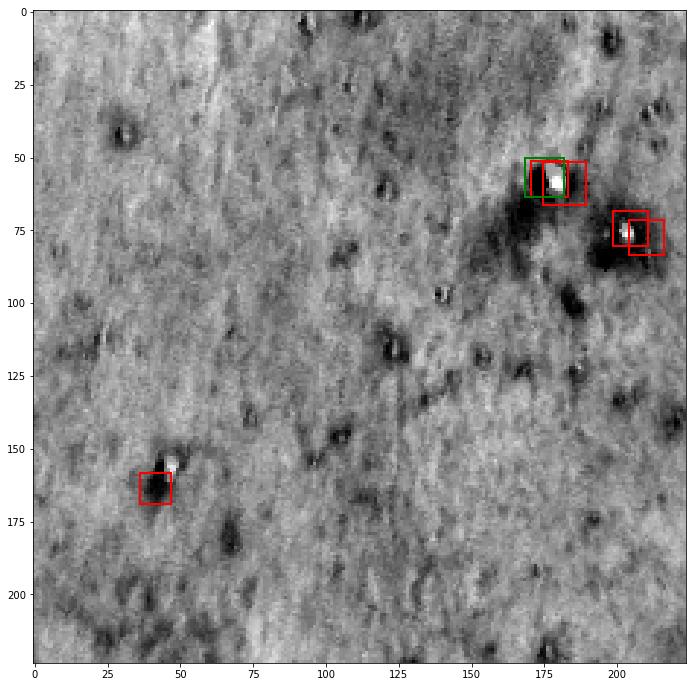

In [34]:
# Draw the predicted boxes onto the image

i = 0

fig, ax = plt.subplots(figsize=(20,12))
ax.imshow(X_test[0], cmap=plt.cm.gray)

# Draw the predicted boxes in red
for conf, x, y, r in y_pred[i][-5:]:
    ax.add_patch(plt.Rectangle((y - r, x - r), r*2, r*2, color='red', fill=False, linewidth=2))  

# Draw the ground truth boxes in green (omit the label for more clarity)
for x, y, r in y_test[i]:
    ax.add_patch(plt.Rectangle((y-r, x-r), r*2, r*2, color='green', fill=False, linewidth=2))  

In [35]:
import rampwf

In [36]:
from rampwf.score_types.detection import AverageDetectionPrecision, DetectionPrecision, DetectionRecall, SCP

In [37]:
average_precision = AverageDetectionPrecision()
precision = DetectionPrecision()
recall = DetectionRecall()
scp = SCP(shape=(224, 224), minipatch=[56, 168, 56, 168])

In [38]:
ap = average_precision(y_test[:500], y_pred)
ap

/Users/yetkin/ramp/ramp-workflow/rampwf/score_types/detection.py:453: RuntimeWarning: invalid value encountered in long_scalars
  return n_pred_correct / n_pred_all


0.52543678155606277

In [39]:
precision(y_test[:500], y_pred)

0.44401544401544402

In [40]:
recall(y_test[:500], y_pred)

0.6267029972752044

Those number depend on the confidence threshold:

In [41]:
ps = []
rs = []
scps = []

for conf_threshold in np.linspace(0, 1, 50):
    ps.append(precision(y_test[:100], y_pred, conf_threshold=conf_threshold))
    rs.append(recall(y_test[:100], y_pred, conf_threshold=conf_threshold))
    scps.append(scp(y_test[:100], y_pred, conf_threshold=conf_threshold))
    
ps = np.array(ps)
rs = np.array(rs)
scps = np.array(scps)

/Users/yetkin/ramp/ramp-workflow/rampwf/score_types/detection.py:453: RuntimeWarning: invalid value encountered in long_scalars
  return n_pred_correct / n_pred_all


Precision-recall curve:

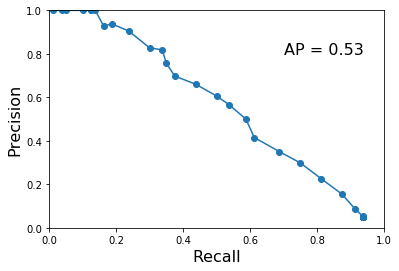

In [42]:
fig, ax = plt.subplots()
ax.plot(rs, ps, 'o-')
ax.set_xlabel('Recall', fontsize=16)
ax.set_ylabel('Precision', fontsize=16)
ax.set(xlim=(0, 1), ylim=(0, 1))
ax.text(0.7, 0.8, 'AP = {:.2f}'.format(ap), fontsize=16)

SCP, precision and recall in function of the confidence threshold:

In [43]:
conf_thresholds = np.linspace(0, 1, 50)

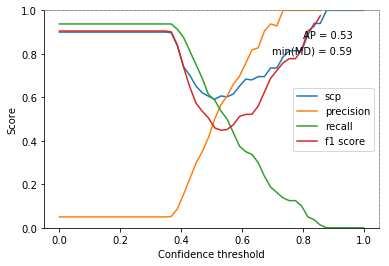

In [44]:
fig, ax = plt.subplots()
ax.plot(conf_thresholds, scps, label='scp')
ax.plot(conf_thresholds, ps, 'C1', label='precision')
ax.plot(conf_thresholds, rs, 'C2', label='recall')
ax.plot(conf_thresholds, 1 - (2*(ps * rs) / (ps + rs)) , 'C3', label='f1 score')

ax.legend(loc=7)

ax.set_xlabel("Confidence threshold")
ax.set_ylabel("Score")

ax.set_ylim(0, 1)

#ax.axhline(1, linestyle='--', color='grey')
#ax.axvline(conf_thresholds[17], color='grey', linestyle='--')
ax.spines['top'].set(linestyle='--', color='grey')
ax.spines['right'].set(linestyle='--', color='grey')
    
ax.text(0.8, 0.87, 'AP = {:.2f}'.format(ap))
ax.text(0.7, 0.80, 'min(MD) = {:.2f}'.format(np.min(scps)))

## Local testing/exploration

It is <b><span style="color:red">important that you test your submission files before submitting them</span></b>. For this we provide a unit test. Note that the test runs on your files in [`submissions/starting_kit`](/tree/submissions/starting_kit), not on the classes defined in the cells of this notebook.

Check list

- Install the `ramp-workflow` locally

In [45]:
!pip install git+https://github.com/paris-saclay-cds/ramp-workflow

  Cloning https://github.com/paris-saclay-cds/ramp-workflow to /private/var/folders/xs/x4rnyzbd1vsbqhjrfxvc4zm40000gn/T/pip-wtt17a5m-build


- Make sure that the python files `object_detector.py` is in the  [`submissions/starting_kit`](/tree/submissions/starting_kit) folder, and the train and test data are in [`data`](/tree/data)
- If you haven't yet, downlad the images by executing 
  ```
  python download_data.py
  ```

Finally, make sure the local processing goes through by running the
```
ramp_test_submission
```

In [46]:
!ramp_test_submission

Testing Mars craters detection and classification
Reading train and test files from ./data ...
Reading cv ...
Training ./submissions/starting_kit ...
CV fold 0
	train scp = 0.9942
	valid scp = 0.995
	test scp = 0.9938
	train ospa = 0.9899
	valid ospa = 0.9867
	test ospa = 0.9876
/Users/yetkin/ramp/ramp-workflow/rampwf/score_types/detection.py:453: RuntimeWarning: invalid value encountered in long_scalars
  return n_pred_correct / n_pred_all
/Users/yetkin/ramp/ramp-workflow/rampwf/score_types/detection.py:746: RuntimeWarning: All-NaN slice encountered
  p_at_r.append(np.nanmax(p))
	train map = nan
	valid map = nan
	test map = nan
	train prec(0) = 0.5528
	valid prec(0) = 0.3785
	test prec(0) = 0.4728
	train prec(0.5) = 0.0
	valid prec(0.5) = 0.0
	test prec(0.5) = 0.0
	train prec(0.9) = 0.0
	valid prec(0.9) = 0.0
	test prec(0.9) = 0.0
	train rec(0) = 0.587
	valid rec(0) = 0.7035
	test rec(0) = 0.6737
	train rec(0.5) = 0.0
	valid rec(0.5) = 0.0
	test rec(0.5) = 0.0
	train rec(0.9) = 0.0
	v

If you get to see the train and test scores, and no errors, then you can submit your model to the ramp.studio.

## Submitting to [ramp.studio](http://ramp.studio)

Once you found a good model, you can submit them to [ramp.studio](http://www.ramp.studio). First, if it is your first time using RAMP, [sign up](http://www.ramp.studio/sign_up), otherwise [log in](http://www.ramp.studio/login). Then find an open event on the particular problem, for example, the event [MNIST](http://www.ramp.studio/events/MNIST) for this RAMP. Sign up for the event. Both signups are controled by RAMP administrators, so there **can be a delay between asking for signup and being able to submit**.

Once your signup request is accepted, you can go to your [sandbox](http://www.ramp.studio/events/MNIST/sandbox) and copy-paste (or upload) [`image_preprocessor.py`](/edit/submissions/starting_kit/image_preprocessor.py) and [`batch_classifier.py`](/edit/submissions/starting_kit/batch_classifier.py) from `submissions/starting_kit`. Save it, rename it, then submit it. The submission is trained and tested on our backend in the same way as `ramp_test_submission` does it locally. While your submission is waiting in the queue and being trained, you can find it in the "New submissions (pending training)" table in [my submissions](http://www.ramp.studio/events/MNIST/my_submissions). Once it is trained, you get a mail, and your submission shows up on the [public leaderboard](http://www.ramp.studio/events/MNIST/leaderboard). 
If there is an error (despite having tested your submission locally with `ramp_test_submission`), it will show up in the "Failed submissions" table in [my submissions](http://www.ramp.studio/events/MNIST/my_submissions). You can click on the error to see part of the trace.

After submission, do not forget to give credits to the previous submissions you reused or integrated into your submission.

The data set we use at the backend is usually different from what you find in the starting kit, so the score may be different.

The usual way to work with RAMP is to explore solutions, add feature transformations, select models, perhaps do some AutoML/hyperopt, etc., _locally_, and checking them with `ramp_test_submission`. The script prints mean cross-validation scores 
```
----------------------------
train acc = 0.55 ± 0.0
train nll = 14.53 ± 0.0
valid acc = 0.55 ± 0.0
valid nll = 14.65 ± 0.0
test acc = 0.55 ± 0.0
test nll = 14.6 ± 0.0
```
The official score in this RAMP (the first score column after "historical contributivity" on the [leaderboard](http://www.ramp.studio/events/MNIST/leaderboard)) is balanced accuracy aka macro-averaged recall, so the line that is relevant in the output of `ramp_test_submission` is `valid acc = 0.55 ± 0.0`. When the score is good enough, you can submit it at the RAMP.

## More information

You can find more information in the [README](https://github.com/paris-saclay-cds/ramp-workflow/blob/master/README.md) of the [ramp-workflow library](https://github.com/paris-saclay-cds/ramp-workflow).

## Contact

Don't hesitate to [contact us](mailto:admin@ramp.studio?subject=Mars crater notebook).